# Capstone 2: Preprocessing

## Objectives

### From Rubric:
* Creating dummy features
* Scale standardization
* Split data into training and testing subsets

### From mentor: 

## Steps:
* Identify subset of variables for modelling
    * target feature
    * explanatory features (numeric)
    * explanatory features (categorical)
* Categorical variables: dummy/one hot encode
    * create a function that does this based on a list of variables
    * check if there are any ordinal variables?
* Continuous variables: scale/normalize
    * research ways to determine best scaling method
    * create function that does this based on a list of variables
* Training/Test split
    * Consider removing Class A wildfires
    * Train/test split
        * Split 20% of data out for test set
        * confirm distributions are similar.
    * Identify correct training size (may not need everything)
        * Take a subset of your training data. Validation set.
        * Try a simple model (like a decision tree) on a a small subset and then chart performance with increasing subset size.
        * 
    * Re-introduce full set of large wildfires into the smaller training dataset (need to confirm this is okay)
* export tables for modelling:
    * test set
    * training set
    * training subset(?)
        

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import wildfires dataset
wfs = pd.read_csv('wildfires_postEDA.csv')

In [3]:
# review datatypes of each feature
wfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83540 entries, 0 to 83539
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  83540 non-null  int64  
 1   FPA_ID                      83540 non-null  object 
 2   FIRE_NAME                   72342 non-null  object 
 3   SOURCE_REPORTING_UNIT_NAME  83540 non-null  object 
 4   FIRE_YEAR                   83540 non-null  int64  
 5   DISCOVERY_DT                83540 non-null  object 
 6   DISCOVERY_DOY               83540 non-null  int64  
 7   STAT_CAUSE_DESCR            83540 non-null  object 
 8   COUNTY_NAME                 83540 non-null  object 
 9   LATITUDE                    83540 non-null  float64
 10  LONGITUDE                   83540 non-null  float64
 11  geometry                    83540 non-null  object 
 12  FIRE_SIZE                   83540 non-null  float64
 13  FIRE_SIZE_CLASS             835

In [4]:
# review column names
wfs.columns

Index(['Unnamed: 0', 'FPA_ID', 'FIRE_NAME', 'SOURCE_REPORTING_UNIT_NAME',
       'FIRE_YEAR', 'DISCOVERY_DT', 'DISCOVERY_DOY', 'STAT_CAUSE_DESCR',
       'COUNTY_NAME', 'LATITUDE', 'LONGITUDE', 'geometry', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'elevation', 'slope', 'aspect', 'mean_monthly_ppt',
       'dew_point', 'max_temp', 'wind_speed', 'erc', 'bi', 'fm100', 'fm1000',
       'WHRNAME', 'WHR10NAME', 'US_L3NAME', 'NA_L2NAME', 'usda_bp', 'usda_fi1',
       'usda_fi2', 'usda_fi3', 'usda_fi4', 'usda_fi5', 'usda_fi6',
       'DISCOVERY_MONTH', 'monthly_large_wf', 'aspect_cat', 'FIRE_SIZE_log',
       'FIRE_SIZE_boxcox'],
      dtype='object')

In [5]:
target_feature = ['FIRE_SIZE_CLASS']

# list of continuous explanatory features
exp_cont = ['LATITUDE', 'LONGITUDE','elevation', 'slope', 'aspect', 'mean_monthly_ppt',
            'dew_point', 'max_temp', 'wind_speed', 'erc', 'bi', 'fm100', 'fm1000','usda_bp',
            'usda_fi1', 'usda_fi2', 'usda_fi3', 'usda_fi4','monthly_large_wf']

# list of categorical explanatory features
exp_cat = ['DISCOVERY_MONTH','WHR10NAME', 'aspect_cat','NA_L2NAME','US_L3NAME']

In [6]:
#override negative elevations to be 0 (to avoid scaling issues later on)
wfs.elevation = wfs.elevation.clip(lower=0)

In [7]:
#dropping all records with Fire Size Class of A
wfs = wfs[wfs.FIRE_SIZE_CLASS != 'A']

In [8]:
wfs.shape

(40603, 41)

## Transforming Continuous Variables

In [9]:
# get summary statistics + skew/kurtosis for each continuous feature
wfs_describe = wfs[exp_cont].describe().T
wfs_describe['skew'] = wfs[wfs_describe.index].skew()
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
wfs_describe['skew_class'] = pd.cut(abs(wfs_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
wfs_describe['kurtosis'] = wfs[wfs_describe.index].kurtosis()

In [10]:
# shifting values so there are no negative/0 values
# by adding absolute value of min val to columns with mins <=0
# this is to allow variables to be log transformed
wfs_no_zeros = wfs[exp_cont]
for col in wfs_no_zeros.columns:
    if wfs_no_zeros[col].min() <= 0:
        wfs_no_zeros.loc[:,col] = wfs_no_zeros[col] + abs(wfs_no_zeros[col].min()) + 0.0001

/Users/allankapoor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [11]:
# get summary statistics + skew/kurtosis for each continuous feature (now that feature vales are shifted)
wfs_noZ_describe = wfs_no_zeros.describe().T
wfs_noZ_describe['skew'] = wfs[wfs_noZ_describe.index].skew()

# assign "skew classes" based on general rule of thumb for interpreting skew values
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
wfs_noZ_describe['skew_class'] = pd.cut(abs(wfs_noZ_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
wfs_noZ_describe['kurtosis'] = wfs[wfs_noZ_describe.index].kurtosis()
wfs_noZ_describe

,count,mean,std,min,25%,50%,75%,max,skew,skew_class,kurtosis
LATITUDE,40603.0,37.426451,2.427785,32.552743,35.661393,37.463758,39.308375,42.007800,-0.185589,Low,-0.951326
LONGITUDE,40603.0,4.042380,2.061663,0.000100,2.593797,3.716220,5.377835,10.243900,0.445611,Low,-0.579478
elevation,40603.0,479.978253,522.349135,0.000100,91.553975,291.496530,697.506700,3795.679300,1.661633,High,2.763476
slope,40603.0,6.832351,8.455206,0.000100,0.817248,3.276110,9.741365,73.758584,1.754441,High,2.930586
aspect,40603.0,179.151344,99.709393,0.000100,93.786073,185.855030,260.518745,359.999250,-0.103933,Low,-1.060810
mean_monthly_ppt,40603.0,48.271094,37.757627,0.006417,21.383917,37.337917,63.223747,354.849426,1.755768,High,4.288230
dew_point,40603.0,27.018158,4.981725,0.000100,24.094886,27.798243,30.714529,43.502101,-0.800571,Med,0.775241
max_temp,40603.0,28.360956,6.533056,0.305143,24.076358,29.365000,33.407572,45.421288,-0.568374,Med,-0.159920
wind_speed,40603.0,3.403939,1.541796,0.359634,2.414889,3.063977,3.999138,15.806997,1.814152,High,5.546374
erc,40603.0,61.881827,17.814508,0.000100,49.045733,63.397542,75.613137,114.702241,-0.301532,Low,-0.444059


In [12]:
# here we define a function that for a given column in a dataframe, tests several transformations,
# calculates the skew for each, and then returns a alphabetical code corresponding to the best transformation
def test_transformations(df, col):
        '''
        For col in df, tests several transformations and returns the best transformation and the resulting skew
        '''
    
        #get skew of different transformations
        orig = df[col].skew()
        logn = np.log(df[col]).skew()
        log10 = np.log10(df[col]).skew()
        sqrt = np.sqrt(df[col]).skew()
        cbrt = np.cbrt(df[col]).skew()
        #recip = (1 / df[col]).skew()
        sq = (df[col]**2).skew()
        cb = (df[col]**3).skew()
        
        transformation_list = ['none','logn','log10','sqrt','cbrt','sq','cb'] # 'recip'
        skew_list = [abs(x) for x in [orig, logn, log10, sqrt, cbrt, sq, cb]] # recip
        
        #find min skew
        min_skew = min(skew_list)
        min_index = skew_list.index(min_skew)
        best_transformation = transformation_list[min_index]
        
        print(f'best transformation: {best_transformation}')
        
        print(f'orig skew: {round(orig,3)}')
        print(f'logn skew: {round(logn,3)}')
        print(f'log10 skew: {round(log10,3)}')
        print(f'sqrt skew: {round(sqrt,3)}')
        print(f'cbrt skew: {round(cbrt,3)}')
        #print(f'recip skew: {round(recip,3)}')
        print(f'sq skew: {round(sq,3)}')
        print(f'cb skew: {round(cb,3)}')
        
        return best_transformation, min_skew

In [13]:
#test transformation for each explanatory feature and record
for col in wfs_no_zeros.columns:
    print(f'------- {col} -------')
    
    best, skew = test_transformations(wfs_no_zeros, col)
    
    wfs_noZ_describe.loc[col,'best_trans'] = best
    wfs_noZ_describe.loc[col,'abs_trans_skew'] = skew

------- LATITUDE -------
best transformation: cb
orig skew: -0.186
logn skew: -0.284
log10 skew: -0.284
sqrt skew: -0.235
cbrt skew: -0.251
sq skew: -0.086
cb skew: 0.014
------- LONGITUDE -------
best transformation: sqrt
orig skew: 0.446
logn skew: -1.271
log10 skew: -1.271
sqrt skew: -0.171
cbrt skew: -0.446
sq skew: 1.214
cb skew: 1.806
------- elevation -------
best transformation: cbrt
orig skew: 1.662
logn skew: -4.341
log10 skew: -4.341
sqrt skew: 0.676
cbrt skew: 0.259
sq skew: 3.699
cb skew: 6.177
------- slope -------
best transformation: cbrt
orig skew: 1.754
logn skew: -1.958
log10 skew: -1.958
sqrt skew: 0.728
cbrt skew: 0.282
sq skew: 3.84
cb skew: 7.934
------- aspect -------
best transformation: none
orig skew: -0.104
logn skew: -5.253
log10 skew: -5.253
sqrt skew: -0.835
cbrt skew: -1.379
sq skew: 0.645
cb skew: 1.163
------- mean_monthly_ppt -------
best transformation: cbrt
orig skew: 1.756
logn skew: -0.67
log10 skew: -0.67
sqrt skew: 0.708
cbrt skew: 0.35
sq skew:

In [14]:
# return a table summarizing the transformation tests. We compare the skew of the original data to the skew of
# the transformed data and see that we have been able to reduce skew significantly for most features.

wfs_noZ_describe['trans_skew_class'] = pd.cut(wfs_noZ_describe['abs_trans_skew'], bins, labels=labels, ordered=False, include_lowest=True)

wfs_noZ_describe[['skew','skew_class','best_trans','abs_trans_skew','trans_skew_class']].sort_values('abs_trans_skew', ascending=False)

,skew,skew_class,best_trans,abs_trans_skew,trans_skew_class
usda_fi1,3.485790,High,log10,0.885513,Med
bi,-0.531552,Med,none,0.531552,Med
usda_bp,3.147001,High,cbrt,0.452924,Low
mean_monthly_ppt,1.755768,High,cbrt,0.349571,Low
erc,-0.301532,Low,none,0.301532,Low
slope,1.754441,High,cbrt,0.282283,Low
monthly_large_wf,1.344422,High,cbrt,0.269315,Low
elevation,1.661633,High,cbrt,0.259248,Low
usda_fi4,1.655752,High,log10,0.255755,Low
dew_point,-0.800571,Med,cb,0.218016,Low


In [15]:
# now, we apply the best transformation identified for each continuous feature based on the above process

wfs_trans = wfs_no_zeros.copy()

for col in wfs_trans:
    
    #get best transformation
    trans = wfs_noZ_describe.loc[col,'best_trans']
    
    #apply best transformation
    if trans == 'none':
        wfs_trans[col] = wfs_trans[col]
    elif trans == 'logn':
        wfs_trans[col] = np.log(wfs_trans[col])
    elif trans == 'log10':
        wfs_trans[col] = np.log10(wfs_trans[col])
    elif trans == 'sqrt':
        wfs_trans[col] = np.sqrt(wfs_trans[col])
    elif trans == 'cbrt':
        wfs_trans[col] = np.cbrt(wfs_trans[col])
    elif trans == 'recip':
        wfs_trans[col] = 1/wfs_trans[col]
    elif trans == 'sq':
        wfs_trans[col] = wfs_trans[col]**2
    elif trans == 'cb':
        wfs_trans[col] = wfs_trans[col]**3
    else:
        print(f'error at {col}')

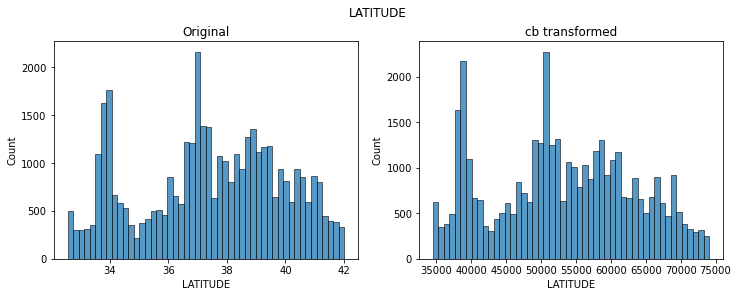

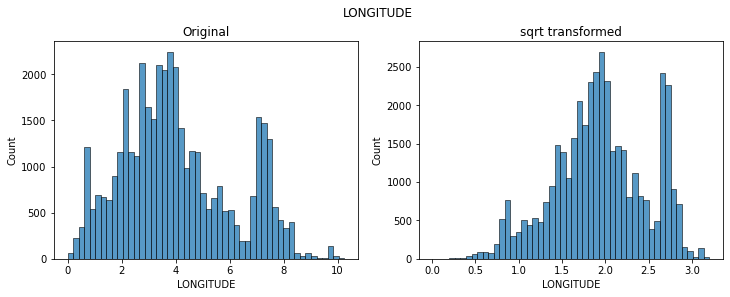

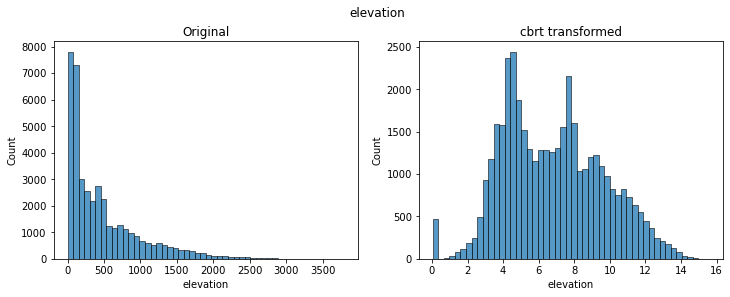

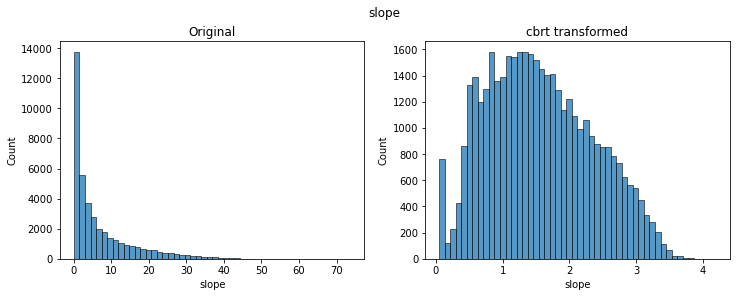

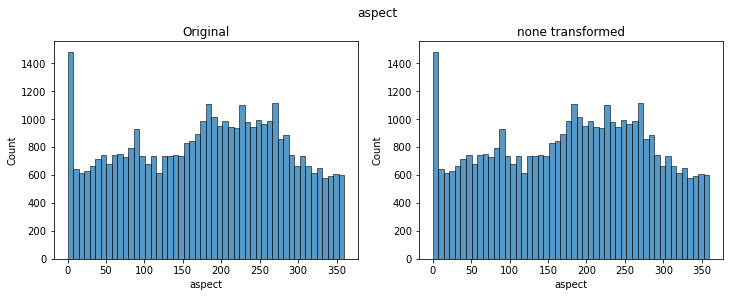

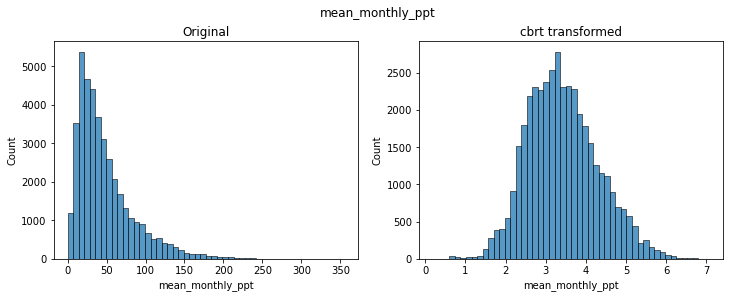

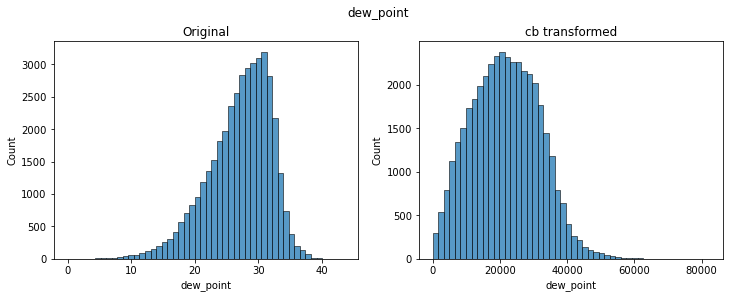

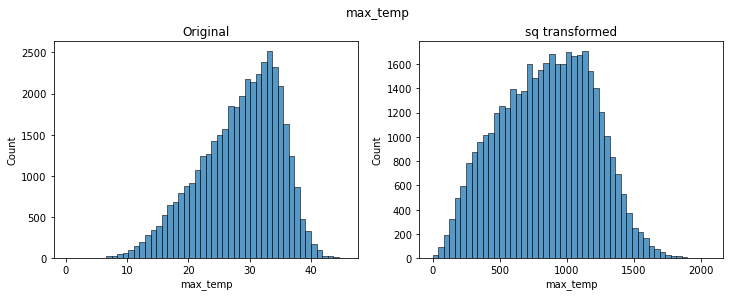

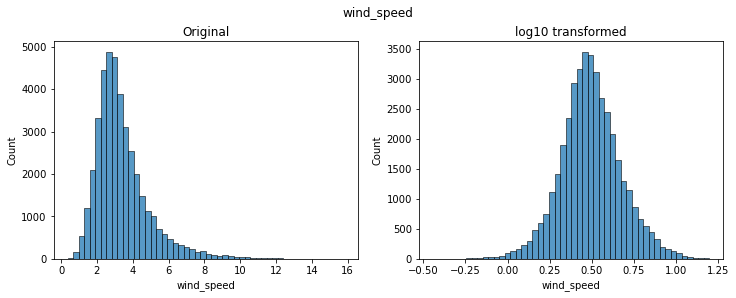

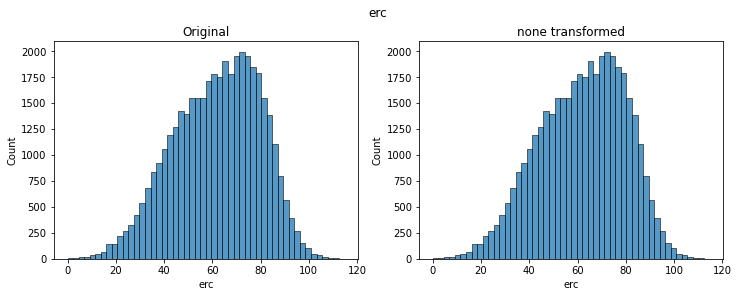

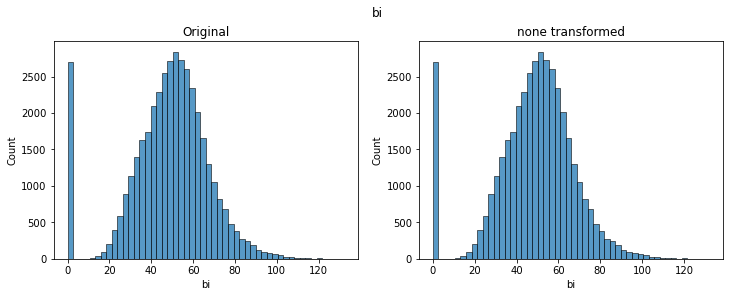

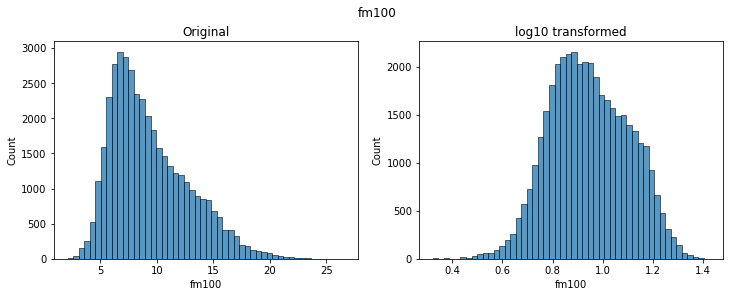

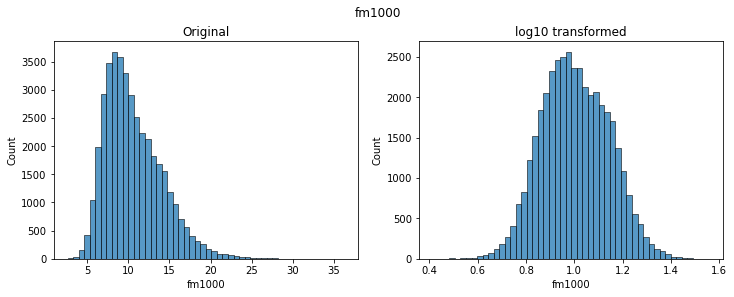

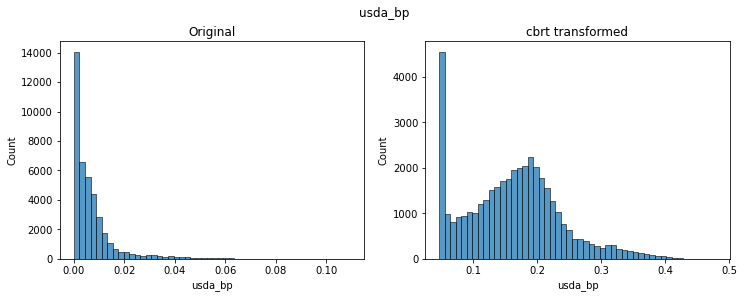

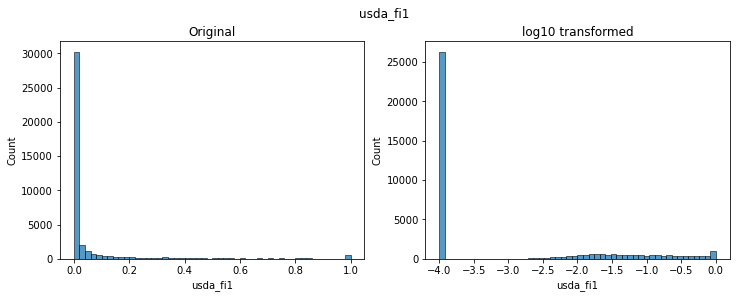

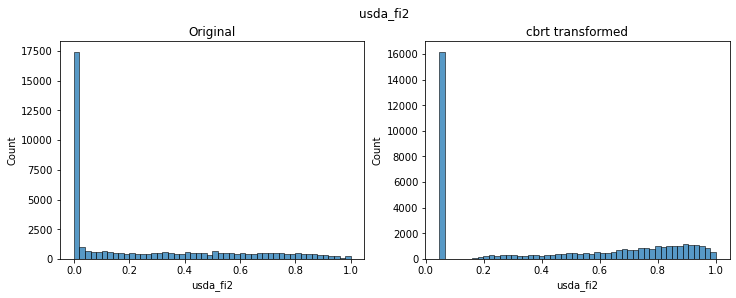

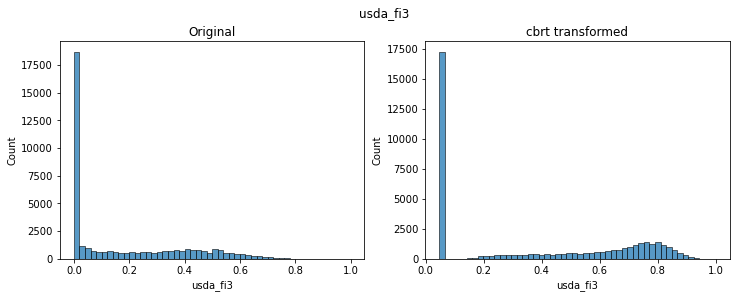

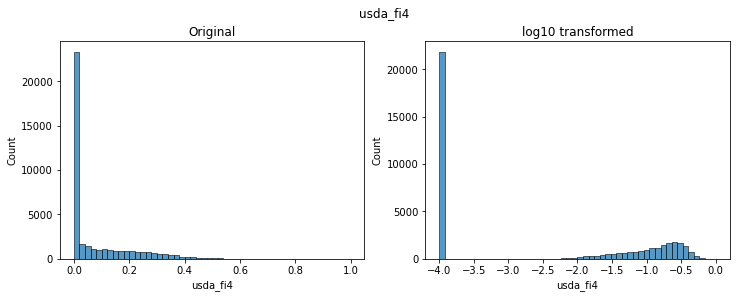

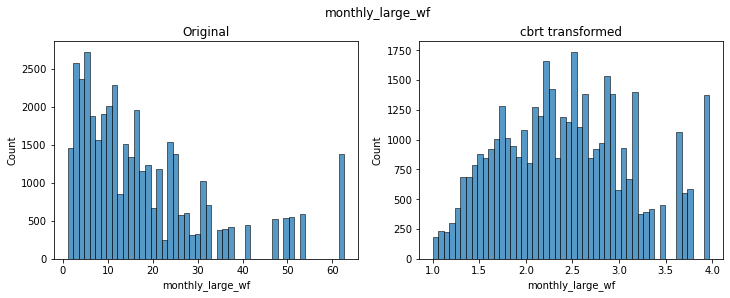

In [130]:
# for each continuous feature, we do a visual inspection comparing the original distribution to the transformed
# distribution. Choosing the transformation that reduces skew the most makes sense, but it is important to make sure
# that the transformation aren't producing problematic results. In general, we want to confirm that transformed
# distribution is actually closer to a normal distribution.

for col in wfs_trans.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

    sns.histplot(x=col, data=wfs_no_zeros, bins=50, ax=ax1)
    ax1.set_title('Original')

    sns.histplot(x=col, data=wfs_trans, bins=50, ax=ax2)
    title = wfs_noZ_describe.loc[col,'best_trans']
    ax2.set_title(f'{title} transformed')

    fig.suptitle(col, y=1.0) 

    plt.show();

In [16]:
wfs_trans.head()

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
1,63268.140847,2.023119,11.845419,2.414584,45.13996,3.940440,3370.826396,185.948290,0.606454,31.053229,29.961724,1.126366,1.268039,0.143987,-0.969631,0.793753,0.685078,-1.145518,1.310371
4,62997.282739,1.954257,11.635882,1.846491,167.01350,3.941304,1128.748466,148.920193,0.678806,45.308881,44.245637,1.027967,1.149550,0.187674,-4.000000,0.313695,0.639588,-0.557484,1.310371
5,62985.409154,1.975112,11.464129,1.163283,324.95300,3.646062,1057.364686,156.367873,0.652441,42.349519,40.321435,1.046028,1.171934,0.177523,-1.438136,0.851914,0.689204,-1.737976,1.310371
6,64632.740505,1.880443,10.257326,2.775995,268.48042,4.728582,2894.485059,124.099586,0.758136,17.560101,0.000101,1.169783,1.300238,0.211271,-4.000000,0.320970,0.784935,-0.578666,1.310371
7,62732.461313,1.960856,11.107087,1.308573,254.73255,4.313399,3051.662747,106.313768,0.734011,45.714009,48.972016,1.057925,1.162887,0.171762,-1.696804,0.920556,0.584901,-4.000000,1.310371


## Encoding Categorical Data

Here we simplify and then dummy encode all categorical variables

In [17]:
wfs[exp_cat]

,DISCOVERY_MONTH,WHR10NAME,aspect_cat,NA_L2NAME,US_L3NAME
1,2,Shrub,NE,WESTERN CORDILLERA,Sierra Nevada
4,2,Conifer,S,WESTERN CORDILLERA,Sierra Nevada
5,2,Hardwood,NW,WESTERN CORDILLERA,Sierra Nevada
6,2,Conifer,W,WESTERN CORDILLERA,Sierra Nevada
7,2,Herbaceous,W,WESTERN CORDILLERA,Sierra Nevada
...,...,...,...,...,...
83532,2,Urban,N,MEDITERRANEAN CALIFORNIA,Central California Foothills and Coastal Mount...
83534,1,Herbaceous,NE,MEDITERRANEAN CALIFORNIA,Central California Foothills and Coastal Mount...
83535,1,Shrub,S,MEDITERRANEAN CALIFORNIA,Central California Foothills and Coastal Mount...
83537,12,Agriculture,N,MEDITERRANEAN CALIFORNIA,Central California Valley


In [18]:
def see_uniques(df):
    ''' print unique values of each obj column'''
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f'----- {col} -----')
            print(f'Num categories: {df[col].nunique()}')
            print(df[col].unique())

In [19]:
exp_cat

['DISCOVERY_MONTH', 'WHR10NAME', 'aspect_cat', 'NA_L2NAME', 'US_L3NAME']

In [20]:
#simplifying category names 
wfs_cat = wfs[exp_cat]
for col in exp_cat[1:]:
    
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace(' ', '_')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('/', '_')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('California', 'CA')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('CALIFORNIA', 'CA')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('Southern', 'S')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('Northern', 'N')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('North', 'N')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('Eastern', 'E')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('WESTERN', 'W')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('WEST', 'W')
    
see_uniques(wfs_cat)

/Users/allankapoor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


----- WHR10NAME -----
Num categories: 10
['Shrub' 'Conifer' 'Hardwood' 'Herbaceous' 'Wetland' 'Water' 'Agriculture'
 'Urban' 'Barren_Other' 'Desert']
----- aspect_cat -----
Num categories: 8
['NE' 'S' 'NW' 'W' 'N' 'SW' 'E' 'SE']
----- NA_L2NAME -----
Num categories: 5
['W_CORDILLERA' 'MEDITERRANEAN_CA' 'MARINE_W_COAST_FOREST' 'WARM_DESERTS'
 'COLD_DESERTS']
----- US_L3NAME -----
Num categories: 13
['Sierra_Nevada' 'Klamath_Mountains_CA_High_N_Coast_Range'
 'Central_CA_Foothills_and_Coastal_Mountains' 'Cascades'
 'E_Cascades_Slopes_and_Foothills' 'Coast_Range' 'S_CA_Mountains'
 'S_CA_N_Baja_Coast' 'Mojave_Basin_and_Range' 'Central_Basin_and_Range'
 'Sonoran_Basin_and_Range' 'Central_CA_Valley' 'N_Basin_and_Range']


In [21]:
#creating dummies for categorical features
wfs_cat_dummies = pd.get_dummies(wfs_cat, columns=['DISCOVERY_MONTH'], drop_first=True, prefix='MONTH')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['aspect_cat'], drop_first=True, prefix='ASPECT')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['WHR10NAME'], drop_first=True, prefix='WHR10')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['NA_L2NAME'], drop_first=True, prefix='L2')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['US_L3NAME'], drop_first=True, prefix='L3')
wfs_cat_dummies.columns

Index(['MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'ASPECT_N',
       'ASPECT_NE', 'ASPECT_NW', 'ASPECT_S', 'ASPECT_SE', 'ASPECT_SW',
       'ASPECT_W', 'WHR10_Barren_Other', 'WHR10_Conifer', 'WHR10_Desert',
       'WHR10_Hardwood', 'WHR10_Herbaceous', 'WHR10_Shrub', 'WHR10_Urban',
       'WHR10_Water', 'WHR10_Wetland', 'L2_MARINE_W_COAST_FOREST',
       'L2_MEDITERRANEAN_CA', 'L2_WARM_DESERTS', 'L2_W_CORDILLERA',
       'L3_Central_Basin_and_Range',
       'L3_Central_CA_Foothills_and_Coastal_Mountains', 'L3_Central_CA_Valley',
       'L3_Coast_Range', 'L3_E_Cascades_Slopes_and_Foothills',
       'L3_Klamath_Mountains_CA_High_N_Coast_Range',
       'L3_Mojave_Basin_and_Range', 'L3_N_Basin_and_Range',
       'L3_S_CA_Mountains', 'L3_S_CA_N_Baja_Coast', 'L3_Sierra_Nevada',
       'L3_Sonoran_Basin_and_Range'],
      dtype='object')

## Merge

Merge the transformed continuous variables and encoded categorical variables back together.

Need to merge:
* wfs_trans_scaled
* wfs_cat_dummies
* wfs_ord (?)

In [22]:
wfs_cat_dummies

,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,...,L3_Central_CA_Valley,L3_Coast_Range,L3_E_Cascades_Slopes_and_Foothills,L3_Klamath_Mountains_CA_High_N_Coast_Range,L3_Mojave_Basin_and_Range,L3_N_Basin_and_Range,L3_S_CA_Mountains,L3_S_CA_N_Baja_Coast,L3_Sierra_Nevada,L3_Sonoran_Basin_and_Range
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83532,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83537,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:
wfs_trans

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
1,63268.140847,2.023119,11.845419,2.414584,45.139960,3.940440,3370.826396,185.948290,0.606454,31.053229,29.961724,1.126366,1.268039,0.143987,-0.969631,0.793753,0.685078,-1.145518,1.310371
4,62997.282739,1.954257,11.635882,1.846491,167.013500,3.941304,1128.748466,148.920193,0.678806,45.308881,44.245637,1.027967,1.149550,0.187674,-4.000000,0.313695,0.639588,-0.557484,1.310371
5,62985.409154,1.975112,11.464129,1.163283,324.953000,3.646062,1057.364686,156.367873,0.652441,42.349519,40.321435,1.046028,1.171934,0.177523,-1.438136,0.851914,0.689204,-1.737976,1.310371
6,64632.740505,1.880443,10.257326,2.775995,268.480420,4.728582,2894.485059,124.099586,0.758136,17.560101,0.000101,1.169783,1.300238,0.211271,-4.000000,0.320970,0.784935,-0.578666,1.310371
7,62732.461313,1.960856,11.107087,1.308573,254.732550,4.313399,3051.662747,106.313768,0.734011,45.714009,48.972016,1.057925,1.162887,0.171762,-1.696804,0.920556,0.584901,-4.000000,1.310371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83532,54676.936376,1.379092,1.325739,0.046416,0.000100,3.262200,19809.396973,287.350958,0.480123,31.129607,30.363057,1.142012,1.272958,0.046416,-4.000000,0.046416,0.046416,-4.000000,1.000000
83534,56169.346024,1.506464,4.444428,1.805576,56.448598,2.296524,12503.945832,266.496309,0.310306,43.673898,33.593335,1.178965,1.142467,0.197549,-4.000000,0.699705,0.790113,-0.821642,1.259921
83535,56627.894981,1.529466,8.031076,2.529796,201.643440,2.321341,4973.528458,350.705860,0.022281,52.007363,30.287034,1.027134,1.095128,0.163079,-4.000000,0.775711,0.811011,-4.000000,1.259921
83537,62365.554436,1.551972,3.341027,0.046416,0.000100,2.384624,7238.610752,239.002755,0.366826,33.029012,0.000104,1.089823,1.137408,0.086153,-0.079129,0.550432,0.046416,-4.000000,1.000000


In [26]:
wfs_preprocessed = pd.concat([wfs_trans, wfs_cat_dummies], axis=1)

In [27]:
wfs_preprocessed

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,...,L3_Central_CA_Valley,L3_Coast_Range,L3_E_Cascades_Slopes_and_Foothills,L3_Klamath_Mountains_CA_High_N_Coast_Range,L3_Mojave_Basin_and_Range,L3_N_Basin_and_Range,L3_S_CA_Mountains,L3_S_CA_N_Baja_Coast,L3_Sierra_Nevada,L3_Sonoran_Basin_and_Range
1,63268.140847,2.023119,11.845419,2.414584,45.139960,3.940440,3370.826396,185.948290,0.606454,31.053229,...,0,0,0,0,0,0,0,0,1,0
4,62997.282739,1.954257,11.635882,1.846491,167.013500,3.941304,1128.748466,148.920193,0.678806,45.308881,...,0,0,0,0,0,0,0,0,1,0
5,62985.409154,1.975112,11.464129,1.163283,324.953000,3.646062,1057.364686,156.367873,0.652441,42.349519,...,0,0,0,0,0,0,0,0,1,0
6,64632.740505,1.880443,10.257326,2.775995,268.480420,4.728582,2894.485059,124.099586,0.758136,17.560101,...,0,0,0,0,0,0,0,0,1,0
7,62732.461313,1.960856,11.107087,1.308573,254.732550,4.313399,3051.662747,106.313768,0.734011,45.714009,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83532,54676.936376,1.379092,1.325739,0.046416,0.000100,3.262200,19809.396973,287.350958,0.480123,31.129607,...,0,0,0,0,0,0,0,0,0,0
83534,56169.346024,1.506464,4.444428,1.805576,56.448598,2.296524,12503.945832,266.496309,0.310306,43.673898,...,0,0,0,0,0,0,0,0,0,0
83535,56627.894981,1.529466,8.031076,2.529796,201.643440,2.321341,4973.528458,350.705860,0.022281,52.007363,...,0,0,0,0,0,0,0,0,0,0
83537,62365.554436,1.551972,3.341027,0.046416,0.000100,2.384624,7238.610752,239.002755,0.366826,33.029012,...,1,0,0,0,0,0,0,0,0,0


### Train/Test/Validation Split

In [83]:
from sklearn.model_selection import train_test_split

# Create feature and target arrays
X = wfs_preprocessed
y = wfs.FIRE_SIZE_CLASS

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

LATITUDE


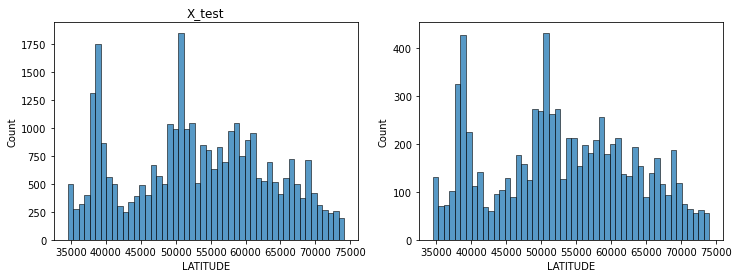

LONGITUDE


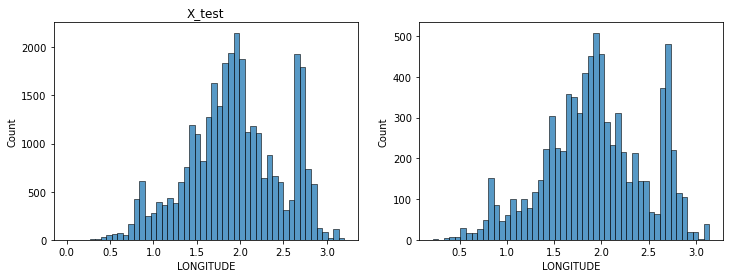

elevation


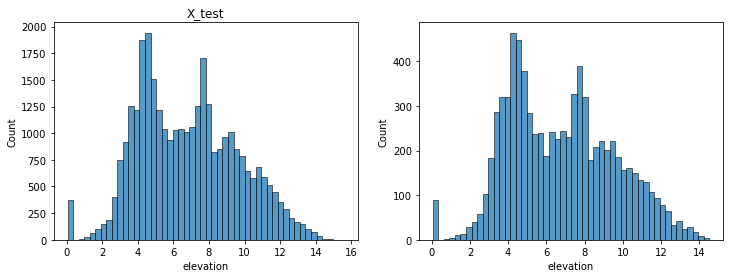

slope


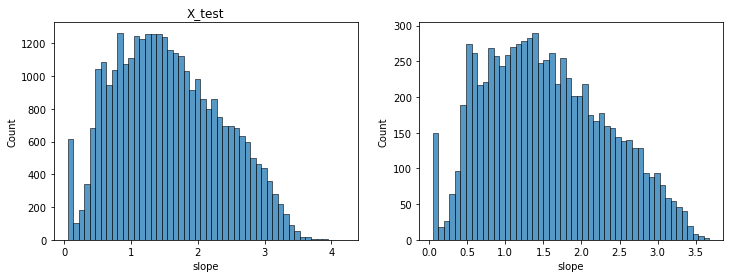

aspect


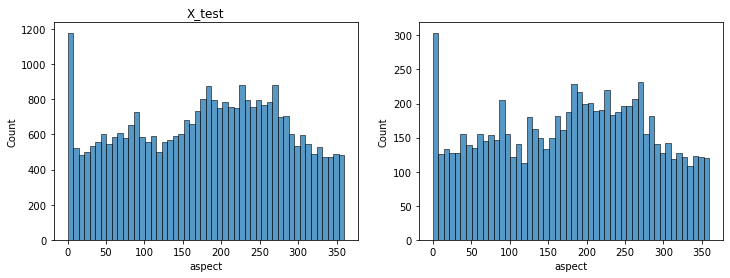

mean_monthly_ppt


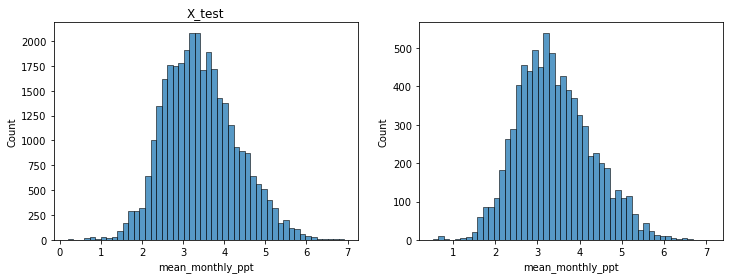

dew_point


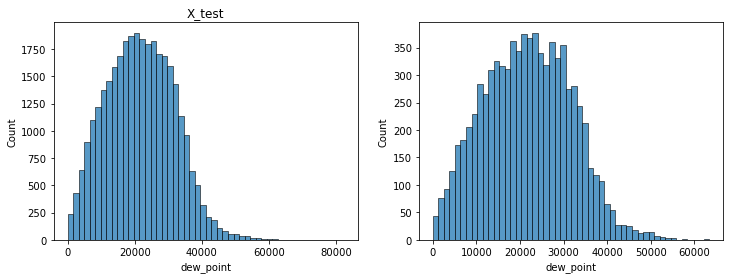

max_temp


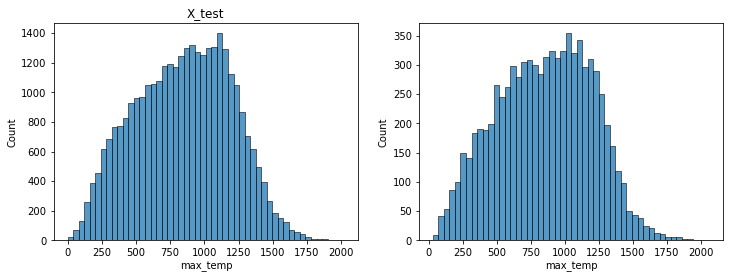

wind_speed


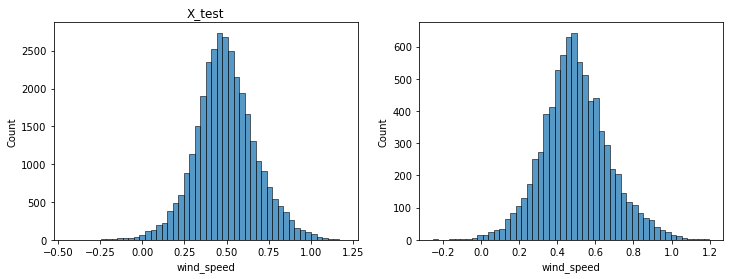

In [84]:
#confirm distributions look similar between training and test splits
for col in X_train.columns[:9]:
    print(col)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

    sns.histplot(x=col, data=X_train, bins=50, ax=ax1)
    ax1.set_title('X_train')
    
    sns.histplot(x=col, data=X_test, bins=50, ax=ax2)
    ax1.set_title('X_test')


    plt.show();

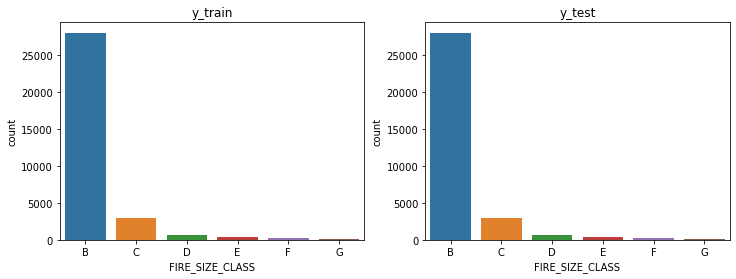

In [85]:
# compare distribution of target vategorical variable between training and test splits
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

order=['B','C','D','E','F','G']

sns.countplot(x=y_train, ax=ax1, order=order)
ax1.set_title('y_train')

sns.countplot(x=y_train, ax=ax2, order=order)
ax2.set_title('y_test');

In [86]:
X_train

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,...,L3_Central_CA_Valley,L3_Coast_Range,L3_E_Cascades_Slopes_and_Foothills,L3_Klamath_Mountains_CA_High_N_Coast_Range,L3_Mojave_Basin_and_Range,L3_N_Basin_and_Range,L3_S_CA_Mountains,L3_S_CA_N_Baja_Coast,L3_Sierra_Nevada,L3_Sonoran_Basin_and_Range
55411,50337.144638,2.116093,4.562238,0.558565,325.765570,2.353287,43892.359847,1607.998558,0.538581,79.514741,...,1,0,0,0,0,0,0,0,0,0
25509,67100.477215,1.419894,5.912173,1.282654,351.477460,4.212118,11601.874296,790.340818,0.261493,54.794358,...,0,0,0,0,0,0,0,0,0,0
10985,60991.092021,1.640532,3.017759,0.561286,268.732800,3.247685,25758.513495,1203.743004,0.163333,73.988267,...,1,0,0,0,0,0,0,0,0,0
54885,65140.036306,1.463713,4.955538,2.008999,51.417905,4.185776,25696.142187,1158.128313,0.492957,79.725190,...,0,0,0,0,0,0,0,0,0,0
51008,39221.211525,2.671602,8.190553,1.327037,198.737300,2.628701,24189.759702,458.290255,0.527622,42.596269,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26922,70619.974918,1.847584,11.484675,2.660582,0.704354,3.719375,15701.920847,944.807109,0.363804,68.041200,...,0,0,1,0,0,0,0,0,0,0
24944,63037.792386,1.062462,7.578965,0.798899,22.014344,3.904387,20086.794778,1254.313347,0.633103,56.135487,...,0,0,0,1,0,0,0,0,0,0
75862,56745.511276,1.434657,3.638397,1.448119,239.089490,3.585284,21291.673080,747.311563,0.465674,50.328130,...,0,0,0,0,0,0,0,0,0,0
70022,53664.558077,1.654992,6.752077,0.869102,81.039506,3.218470,27172.279339,709.933180,0.443196,72.360703,...,0,0,0,0,0,0,0,0,0,0


In [87]:
X_test

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,...,L3_Central_CA_Valley,L3_Coast_Range,L3_E_Cascades_Slopes_and_Foothills,L3_Klamath_Mountains_CA_High_N_Coast_Range,L3_Mojave_Basin_and_Range,L3_N_Basin_and_Range,L3_S_CA_Mountains,L3_S_CA_N_Baja_Coast,L3_Sierra_Nevada,L3_Sonoran_Basin_and_Range
22123,43034.545491,2.828729,7.628763,1.853826,210.426550,1.965254,19805.632159,1686.686281,0.467949,89.704499,...,0,0,0,0,1,0,0,0,0,0
71240,45346.525496,1.947637,6.459802,0.894343,319.100720,2.870446,12673.014389,952.665872,0.466643,69.824601,...,0,0,0,0,0,0,0,0,0,0
38055,71670.936934,1.356032,9.586596,1.236124,63.293095,3.084181,13467.852326,898.714715,0.422947,65.537446,...,0,0,1,0,0,0,0,0,0,0
64612,55791.868291,1.946510,8.307258,3.023035,200.290060,3.640929,15513.756428,474.978463,0.492769,40.831654,...,0,0,0,0,0,0,0,0,1,0
56726,63213.376185,1.541138,3.671738,0.517619,180.000100,4.098274,38630.974164,1117.822791,0.190811,48.777203,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10381,46376.838614,2.274975,4.551513,0.460829,240.432080,3.013446,36129.490832,1109.089903,0.572599,70.708131,...,1,0,0,0,0,0,0,0,0,0
34819,68103.366425,1.788842,11.808162,1.877186,83.157920,3.153514,8991.812721,879.351192,0.612381,80.844132,...,0,0,0,0,0,0,0,0,0,0
4558,45374.083173,2.433724,9.708563,3.034210,183.459110,2.818283,18492.705647,629.027923,0.840274,67.667649,...,0,0,0,0,0,0,0,0,0,0
1872,54773.246382,2.357851,13.436220,1.528393,327.504800,3.353376,4742.684694,660.937951,0.481284,82.979256,...,0,0,0,0,0,0,0,0,0,0


## Scaling Continuous Data

We do this after the train/test split because we want to only fit our scaler to the training dataset in order to prevent leakage.


Summary of different scaling options:

https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

https://www.kaggle.com/getting-started/113219



In [88]:
X_train[wfs_trans.columns].describe()

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
count,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000,32482.000000
mean,53097.050690,1.937681,6.814356,1.563523,179.427224,3.424759,21610.790387,846.227144,0.493777,61.851159,48.308879,0.943733,1.004158,0.161801,-3.012421,0.438812,0.381652,-2.580457,2.426041
std,10130.145788,0.536544,2.799679,0.787254,99.733272,0.882404,10126.131859,350.787379,0.180299,17.839151,19.501375,0.156470,0.138743,0.075823,1.406106,0.361094,0.322935,1.559619,0.703550
min,34495.525756,0.010000,0.046416,0.046416,0.000100,0.185825,6.118018,0.093112,-0.444139,0.000100,0.000100,0.322353,0.414144,0.046416,-4.000000,0.046416,0.046416,-4.000000,1.000000
25%,45369.250028,1.611085,4.518036,0.940285,94.147712,2.780081,13958.775605,577.798032,0.382487,48.996004,38.562132,0.828180,0.903208,0.106474,-4.000000,0.046416,0.046416,-4.000000,1.871980
50%,52634.453803,1.928287,6.643514,1.490400,185.984655,3.349782,21423.801653,861.892152,0.486307,63.359219,49.983149,0.934920,0.997963,0.163357,-4.000000,0.459978,0.360819,-4.000000,2.404967
75%,60729.213376,2.319997,8.883161,2.140221,260.853037,3.987690,28945.431647,1115.345361,0.602187,75.625705,60.143087,1.061086,1.105935,0.206274,-1.679169,0.793753,0.717689,-0.870143,2.895276
max,74129.285266,3.200609,15.598991,4.193766,359.999250,6.918318,82324.801342,2022.313704,1.198693,114.702241,132.171216,1.424705,1.559613,0.478680,0.000043,1.000033,1.000033,0.000043,3.971464


In [89]:
from sklearn.preprocessing import MinMaxScaler

# instantiate scaler
scaler = MinMaxScaler()

# fit scaler and transform training data
X_train.loc[:,wfs_trans.columns] = scaler.fit_transform(X_train[wfs_trans.columns])

# now scale test data based on model fit to training data
X_test.loc[:,wfs_trans.columns] = scaler.transform(X_test[wfs_trans.columns])

/Users/allankapoor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/allankapoor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [90]:
# confirming everything is scaled correctly
X_train.describe().loc[['min','max','mean','50%'],:]

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,...,L3_Central_CA_Valley,L3_Coast_Range,L3_E_Cascades_Slopes_and_Foothills,L3_Klamath_Mountains_CA_High_N_Coast_Range,L3_Mojave_Basin_and_Range,L3_N_Basin_and_Range,L3_S_CA_Mountains,L3_S_CA_N_Baja_Coast,L3_Sierra_Nevada,L3_Sonoran_Basin_and_Range
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
mean,0.469335,0.604173,0.435165,0.365802,0.498410,0.481090,0.262452,0.418418,0.570914,0.539232,...,0.212979,0.031833,0.021089,0.079644,0.022382,0.002278,0.031279,0.13078,0.094329,0.029093
50%,0.457664,0.601229,0.424180,0.348170,0.516625,0.469953,0.260180,0.426165,0.566367,0.552380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


### Final Export

In [91]:
#train
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')

#test
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')





If model is not performing sufficiently, try this later:


### Cyclical Ordinal

Month and aspect are actually cyclic ordinal categories so can be treated differently:

https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes


Also remember to look at the functions in the Baysesian Optimization notebook

In [ ]:
#list of cardinal directions in clockwise order
cardinal_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

wfs_cat.loc[:,'aspect_ord'] = wfs_cat['aspect_cat'].copy()

#replace strings with ordinanl numbers
for i, d in enumerate(cardinal_order):
    wfs_cat.loc[:,'aspect_ord'] = wfs_cat['aspect_ord'].replace(d,i)

#change dtype to int
wfs_cat.loc[:,'aspect_ord'] = wfs_cat['aspect_ord'].astype('float')   

In [ ]:
def create_cyclical_ordinal(col, df):

    num = df[col].nunique()
    df[f'{col}_x']=np.sin(2.*np.pi*df[col]/num)
    df[f'{col}_y']=np.cos(2.*np.pi*df[col]/num)

In [ ]:
create_cyclical_ordinal('aspect_ord',wfs_cat)
wfs_cat

In [1]:
#test